In [2]:
from PIL import Image, ImageDraw
import clip 
import json 
import numpy as np 
import torch 
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import cv2 
from itertools import chain, combinations
import torch.nn.functional as F
import random
from tqdm import tqdm 
import sys 
sys.path.append('..')
sys.path.append('.')
import src.config as config
from torchvision import transforms

In [3]:
from ipywidgets import interact

In [4]:
from ml_collections import config_dict
import torch 
import clip 

setup_dict = {
    # paths
    'raw_data_path': '/data1/saaket/lsd_data/data/raw',
    'interim_save_path': '/data1/saaket/lsd_data/data/interim',
    'processed_save_path': '/data1/saaket/lsd_data/data/processed',
    'valUnseen_data_file': '/data1/saaket/lsd_data/data/raw/way_splits/valUnseen_data.json',
    'train_data_file': '/data1/saaket/lsd_data/data/raw/way_splits/train_data.json',
    'valSenn_data_file': '/data1/saaket/lsd_data/data/raw/way_splits/valSeen_data.json',
    'scan_levels_file': '/data1/saaket/lsd_data/data/raw/floorplans/scan_levels.json',
    'node2pix_file': '/data1/saaket/lsd_data/data/raw/floorplans/allScans_Node2pix.json',
    'geodistance_file': '/data1/saaket/lsd_data/data/raw/geodistance_nodes.json',
    'mesh2meters_file': '/data1/saaket/lsd_data/data/raw/floorplans/pix2meshDistance.json',
    'floorplans_dir': '/data1/saaket/lsd_data/data/raw/floorplans',
    'figures_path': '../reports/figures',

    # model details 
    'clip_version': 'RN50',
    'device': 'cuda:0' if torch.cuda.is_available() else 'cpu', 
    'tokenizer': clip.tokenize,
    # feature extraction modes 
    'data_mode': 'valUnseen',
    'text_feature_mode': 'one_utterance', 
    'rpn_mode': 'conventional',
    'colors': [(240,0,30), (155,50,210), (255,255,25), (0,10,255), (255,170,230), (0,255,0)],
    'color_names': ['red', 'purple', 'yellow', 'blue', 'pink', 'green'],
    'max_floors': 5,
    'ds_percent': 0.65,

}

config = config_dict.ConfigDict(setup_dict)

In [5]:
processed_data = torch.load('/data1/saaket/lsd_data/data/processed/conventional/best_bbox_arr_train_one_utterance_all_floors.pt')

In [6]:
for i, d in enumerate(processed_data):
    if d['scanName'] == 'SN83YJsR3w2':
        print(i)
        break

2


In [ ]:
with open('/data1/saaket/lsd_data/data/raw/way_splits/train_data.json') as jj:
    valUnseen_data = json.load(jj)

In [17]:

def browse_images(best_bbox_arr)
    n = len(best_bbox_arr)
    def visualize_bboxes(best_bbox_arr, valUnseen_data, example_num, idx):
        bbox_dict = best_bbox_arr[example_num]
        x, y = valUnseen_data[example_num]['finalLocation']['pixel_coord'] 
        ideal_floor = valUnseen_data[example_num]['finalLocation']['floor'] 
        
        floors = bbox_dict['floors']
        unique_floors = list(set(floors.keys()))
        try:
            viz_floor = unique_floors[idx]
        except:
            print("This floor does not include a good bounding box")
            return 
        image = Image.open(f'/data1/saaket/lsd_data/data/raw/floorplans/floor_{viz_floor}/{bbox_dict["scanName"]}_{viz_floor}.png')
        col = [(240,0,30), (155,50,210), (255,255,25), (0,10,255), (255,170,230), (0,255,0)]
        # 'color_names': ['red', 'purple', 'yellow', 'blue', 'pink', 'green'],
        print(floors[viz_floor])
        for i, dd in enumerate(floors[viz_floor]):
            idx, utterance, bbox = dd
            x1, y1, x2, y2 = bbox
            
            rgb = col[i]
            # draw.rectangle((x1, y1, x2, y2), width=2, outline=rgb)
            # draw.multiline_text((x1, y1), utterance, fill=rgb)
            image = paint_bbox(image, bbox, rgb)
        if viz_floor == ideal_floor:
            draw = ImageDraw.Draw(image)
            r = 10
            draw.ellipse([(x-r, y-r), (x+r, y+r)], fill = 'red', outline ='red')
        # return (image, bbox_dict['floors'][viz_floor], viz_floor,bbox_dict['scanName'])
        image.show()
    

In [18]:
# 37
def paint_bbox(image, bbox, color):
    x1, y1, x2, y2 = bbox
    overlay = Image.new('RGBA', image.size, color+(0,))
    draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
    draw.rectangle((x1, y1, x2, y2), fill=color+(50,))

    # Alpha composite these two images together to obtain the desired result.
    image = Image.alpha_composite(image, overlay)
    return image 

In [19]:
im, fl, vf, scan = visualize_bboxes(processed_data, 2, 0)

[(0, 'I am on a landing of a staircase. In the room is a pool table and fireplace with a high back pink chair near the fireplace.', array([374, 318, 454, 463], dtype=int32)), (2, "No. It's a billiard/pool table on the rug. There is a large plant next to the door. I'm on the landing of the staircase.", array([584, 306, 739, 379], dtype=int32))]


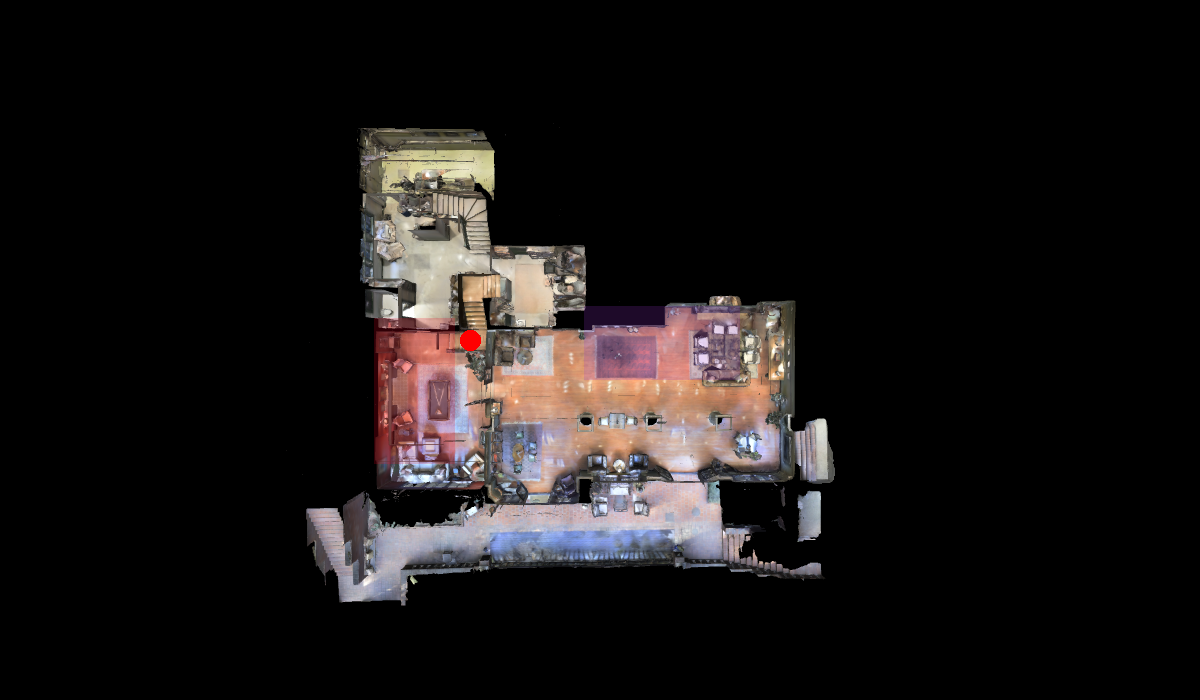

In [20]:
im.save('pooltable.png')

In [ ]:
img = Image.open(
    "{}/floor_{}/{}_{}.png".format(self.config.floorplans_dir, f, sn, f)
).convert('RGBA')
if int(f) in bboxes_on_floors:
    for bb in bboxes_on_floors[int(f)]:
        bbox_idx, _, bbox_coords = bb
        img = self.paint_bbox(img, bbox_coords, bbox_colors[bbox_idx]) 
        self.painted_images.append(img)

In [15]:
class LSDDataset(Dataset):
    def __init__(self, processed_data, config):
        self.data = processed_data
        self.config = config
        self.tokenizer = config.tokenizer
        self.mesh2meters = json.load(open(config.mesh2meters_file))
        self.mode = 'train'
        self.painted_images = []
        self.image_size = [
            3,
            int(700 * self.config.ds_percent),
            int(1200 * self.config.ds_percent),
        ]
        self.preprocess_data_aug = transforms.Compose(
            [
                transforms.ColorJitter(brightness=0.5, hue=0.1, saturation=0.1),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.48145466, 0.4578275, 0.40821073, 0.555], # [0.485, 0.456, 0.406, 0.555],
                    std= [0.26862954, 0.26130258, 0.27577711, 0.222]# [0.229, 0.224, 0.225, 0.222],
                ),
            ]
        )
        self.preprocess = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.48145466, 0.4578275, 0.40821073, 0.555], # [0.485, 0.456, 0.406, 0.555],
                    std= [0.26862954, 0.26130258, 0.27577711, 0.222]# [0.229, 0.224, 0.225, 0.222],
                ),
            ]
        )
    def __len__(self):
        return len(self.data)
    
    def gather_all_floors(self, idx):
        all_maps = torch.zeros(
            self.config.max_floors,
            self.image_size[0],
            self.image_size[1],
            self.image_size[2],
        )
        all_conversions = torch.zeros(self.config.max_floors, 1)
        sn = self.data[idx]['scanName']
        floors = self.mesh2meters[sn].keys()
        bboxes_on_floors = self.data[idx]['floors']
        bboxes = self.data[idx]['bboxes']
        bbox_colors = self.config.colors[:len(bboxes)]

        for enum, f in enumerate(floors):
            img = Image.open(
                "{}/floor_{}/{}_{}.png".format(self.config.floorplans_dir, f, sn, f)
            ).convert('RGBA')
            if int(f) in bboxes_on_floors:
                for bb in bboxes_on_floors[int(f)]:
                    bbox_idx, _, bbox_coords = bb
                    img = self.paint_bbox(img, bbox_coords, bbox_colors[bbox_idx]) 
                    self.painted_images.append(img)


            img = img.resize((self.image_size[2], self.image_size[1]))
            if "train" in self.mode:
                all_maps[enum, :, :, :] = self.preprocess_data_aug(img)[:3, :, :]
            else:
                all_maps[enum, :, :, :] = self.preprocess(img)[:3, :, :]
            all_conversions[enum, :] = self.mesh2meters[sn][f]["threeMeterRadius"] / 3.0

        return all_maps, all_conversions
    
    def paint_bbox(self, image, bbox, color):
        x1, y1, x2, y2 = bbox
        overlay = Image.new('RGBA', image.size, color+(0,))
        draw = ImageDraw.Draw(overlay)  # Create a context for drawing things on it.
        draw.rectangle((x1, y1, x2, y2), fill=color+(50,))

        # Alpha composite these two images together to obtain the desired result.
        image = Image.alpha_composite(image, overlay)
        return image 
    
    def __getitem__(self, idx):
        maps, conversions = self.gather_all_floors(idx)
    
        return {
            'maps': maps, 
            'conversions': conversions,
            'paints': self.painted_images
        }
        

        
        

In [16]:
train_dataset = LSDDataset(processed_data, config)

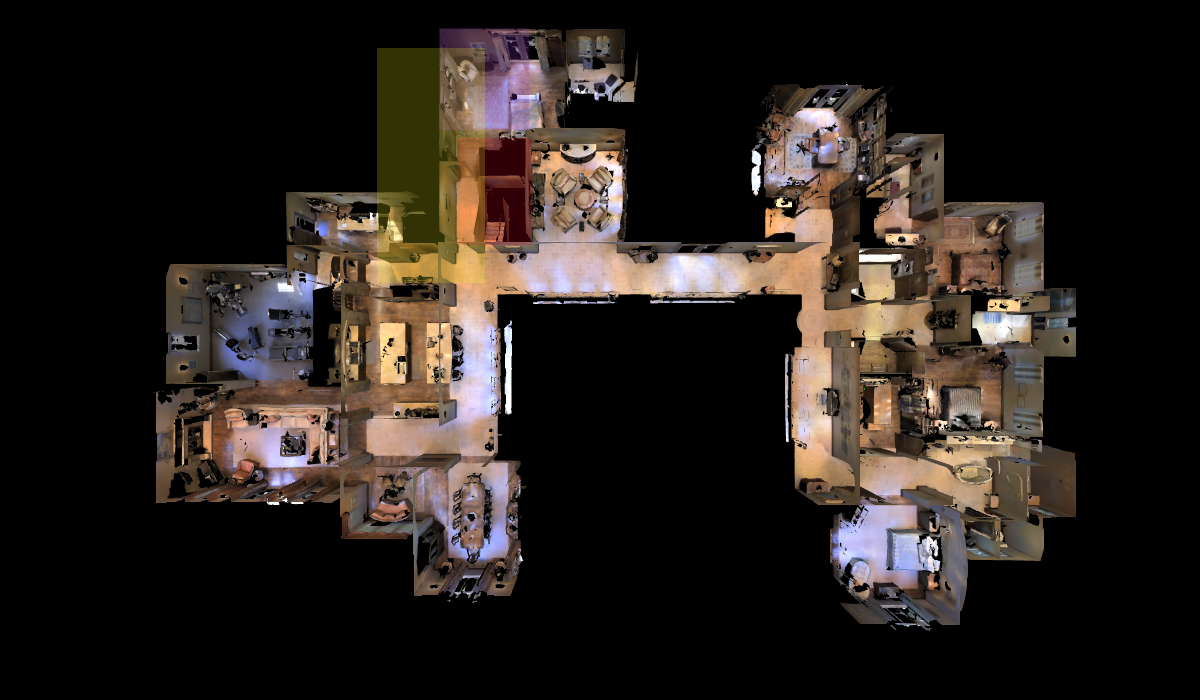

In [30]:
train_dataset[100]['paints'][2]

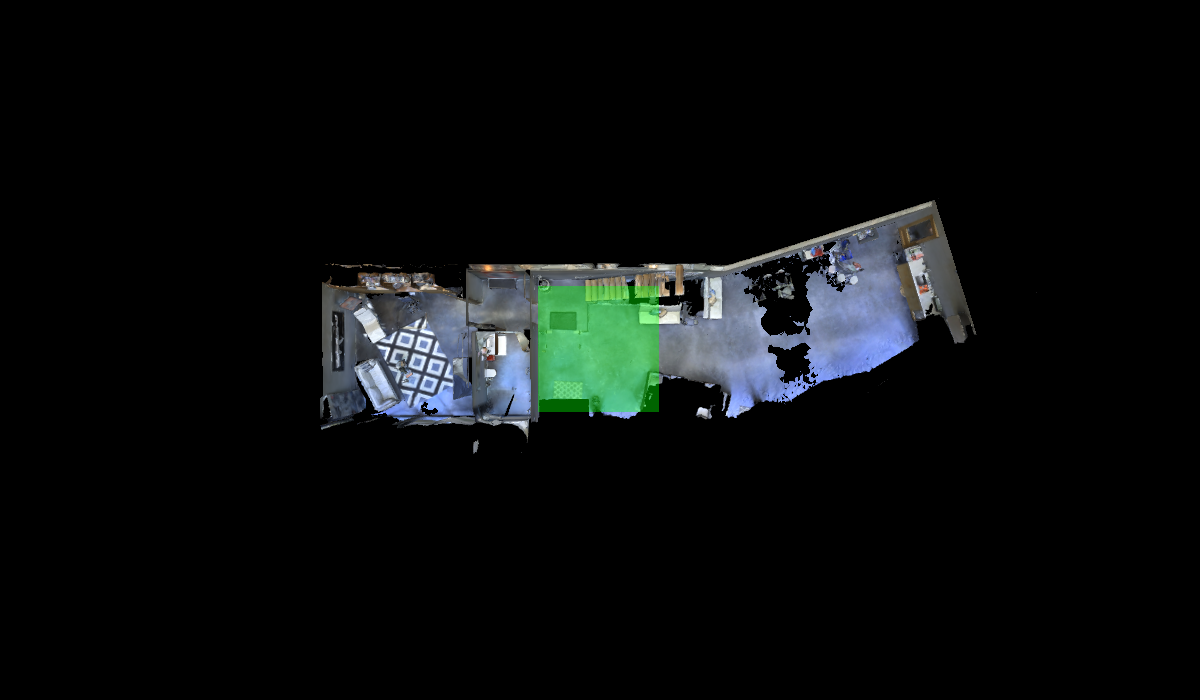

In [18]:
painted_images[0]

In [ ]:
# dialog_array = self.data[idx]['processed_dialog_array']
#         episode_id = self.data[idx]['episode_id']
#         scan_name = self.data[idx]['scan_name']
#         bboxes = self.data[idx]['bboxes']
#         final_pixel_location = self.data[idx]['finalLocation']['pixel_coord']
#         final_viewpoint = self.data[idx]['finalLocation']['viewPoint']
#         self.floor = self.data[idx]['finalLocation']['floor']